# Лабораторная работа №4
# Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей

### Цель лабораторной работы
Изучение сложных способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

### Задание
1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
3. Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. Оцените качество модели с помощью подходящих для задачи метрик.
4. Постройте модель и оцените качество модели с использованием кросс-валидации.
5. Произведите подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации.

# Загрузка данных

In [62]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

iri = load_iris()
for x in iri:
    print(x)

data
target
target_names
DESCR
feature_names
filename


In [63]:
data = pd.DataFrame(data= np.c_[iri['data'], iri['target']],
                     columns= iri['feature_names'] + ['target'])

In [64]:
data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


# Разделение выборки на обучающую и тестовую

In [65]:
X_train, X_test, Y_train, Y_test = train_test_split(iri.data, iri.target, test_size=0.25, random_state=1)

In [66]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((112, 4), (38, 4), (112,), (38,))

# Обучение модели ближайших соседей для произвольно заданного гиперпараметра K

In [67]:
# 3 ближайших соседа
# Метрика accuracy вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов
cl1_1 = KNeighborsClassifier(n_neighbors=3)
cl1_1.fit(X_train, Y_train)
target1_0 = cl1_1.predict(X_train)
target1_1 = cl1_1.predict(X_test)
accuracy_score(Y_train, target1_0), accuracy_score(Y_test, target1_1)

(0.9464285714285714, 1.0)

In [68]:
# 7 ближайших соседей
# Метрика accuracy вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов
cl1_2 = KNeighborsClassifier(n_neighbors=7)
cl1_2.fit(X_train, Y_train)
target2_0 = cl1_2.predict(X_train)
target2_1 = cl1_2.predict(X_test)
accuracy_score(Y_train, target2_0), accuracy_score(Y_test, target2_1)

(0.9642857142857143, 0.9736842105263158)

# Построение модели с использованием кросс-валидации

In [71]:
scores = make_scorer(scores, zero_division=0)

scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), iri.data, iri.target, cv=3)

# Значение метрики accuracy для 3 фолдов
scores

array([0.98, 0.96, 0.98])

In [74]:
# Усредненное значение метрики accuracy для 3 фолдов
np.mean(scores)

0.9754775828460039

In [75]:
# использование метрики precision
scores = cross_val_score(KNeighborsClassifier(n_neighbors=3), 
                         iri.data, iri.target, cv=3,
                        scoring='precision_weighted')
scores, np.mean(scores)

(array([0.98111111, 0.96421053, 0.98111111]), 0.9754775828460039)

In [76]:
# функция cross_validate позволяет использовать для оценки несколько метрик
scoring = {'precision': 'precision_weighted', 
           'jaccard': 'jaccard_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=3), 
                        iri.data, iri.target, scoring=scoring, 
                        cv=2, return_train_score=True)
scores

{'fit_time': array([0.00268006, 0.0004704 ]),
 'score_time': array([0.00897551, 0.00473833]),
 'test_f1': array([0.95998399, 0.91987179]),
 'test_jaccard': array([0.92450142, 0.85696041]),
 'test_precision': array([0.96047009, 0.92163178]),
 'train_f1': array([0.98666133, 0.95998399]),
 'train_jaccard': array([0.97384615, 0.92450142]),
 'train_precision': array([0.98717949, 0.96047009])}

# Подбор гиперпараметра K с использованием GridSearchCV и кросс-валидации

In [77]:
n_range = np.array(range(3,57,3))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 3,  6,  9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51,
         54])}]

In [78]:
%%time
clf_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
clf_gs.fit(X_train, Y_train)

CPU times: user 219 ms, sys: 281 µs, total: 219 ms
Wall time: 231 ms


In [79]:
clf_gs.cv_results_

{'mean_fit_time': array([0.00046797, 0.00041251, 0.00042162, 0.00042205, 0.00041413,
        0.0004055 , 0.0004014 , 0.0003942 , 0.00041513, 0.00042596,
        0.00039253, 0.00039721, 0.00047994, 0.00040751, 0.00034781,
        0.00033731, 0.00040617, 0.00031843]),
 'mean_score_time': array([0.00300083, 0.00155463, 0.00155001, 0.00152822, 0.00155001,
        0.0014894 , 0.00148373, 0.0015327 , 0.0015049 , 0.00150142,
        0.0014864 , 0.00153699, 0.0015861 , 0.0016243 , 0.00271254,
        0.00199056, 0.00193677, 0.00155244]),
 'mean_test_score': array([0.94624506, 0.95573123, 0.97312253, 0.97312253, 0.96403162,
        0.95533597, 0.95533597, 0.94624506, 0.96442688, 0.95533597,
        0.92806324, 0.91936759, 0.93675889, 0.92806324, 0.92806324,
        0.92806324, 0.89288538, 0.88379447]),
 'param_n_neighbors': masked_array(data=[3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42,
                    45, 48, 51, 54],
              mask=[False, False, False, False, False, False, Fa

In [80]:
# Лучшая модель
clf_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [81]:
# Лучшее значение метрики
clf_gs.best_score_

0.9731225296442687

In [82]:
# Лучшее значение параметров
clf_gs.best_params_

{'n_neighbors': 9}

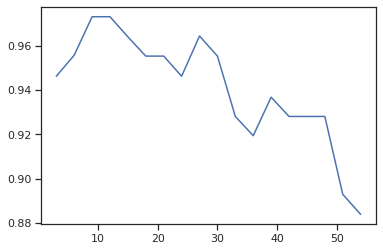

In [83]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, clf_gs.cv_results_['mean_test_score'])

Таким образом, оптимальный гиперпараметр K = 45.